# tutorial https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

## Note to Jose
Working version but not fully understood yet
The next commented think can allow to remove stuff

In [1]:
# Download TorchVision repo to use some files from
# references/detection
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0
!pwd
!cp vision/references/detection/utils.py .
!cp vision/references/detection/transforms.py .
!cp vision/references/detection/coco_eval.py .
!cp vision/references/detection/engine.py .
!cp vision/references/detection/coco_utils.py .

fatal: destination path 'vision' already exists and is not an empty directory.
error: pathspec 'v0.3.0' did not match any file(s) known to git.
/home/jose/ros_ws/src/gr_perception/gr_ml/nb


In [2]:
# Download TorchVision repo to use some files from
# references/detection
!git clone git@github.com:jcmayoral/PyTorch-YOLOv3.git yolov3

fatal: destination path 'yolov3' already exists and is not an empty directory.


In [8]:
from yolov3.models import Darknet

yolobackbone = Darknet(config_path="yolov3/config/yolov3-custom.cfg")
len(yolobackbone.module_list), yolobackbone.out_channels

107


(107, 107)

In [9]:
import numpy as np
import torch
from PIL import Image


class PennFudanDataset(object):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        target["safety_level"] = 0.5

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [10]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [11]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
#backbone = torchvision.models.alexnet(pretrained=False,).features
width_mult = 0.25
#backbone = torchvision.models.mobilenet_v2(pretrained=False, width_mult=width_mult).features

model = yolobackbone
"""
print(backbone.out_channels)
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
#backbone.out_channels = 1280
#backbone.out_channels = int(1280*width_mult)

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
#anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
#                                   aspect_ratios=((0.5, 1.0, 2.0),))
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))
# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                output_size=10,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)
"""

"\nprint(backbone.out_channels)\n# FasterRCNN needs to know the number of\n# output channels in a backbone. For mobilenet_v2, it's 1280\n# so we need to add it here\n#backbone.out_channels = 1280\n#backbone.out_channels = int(1280*width_mult)\n\n# let's make the RPN generate 5 x 3 anchors per spatial\n# location, with 5 different sizes and 3 different aspect\n# ratios. We have a Tuple[Tuple[int]] because each feature\n# map could potentially have different sizes and\n# aspect ratios\n#anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),\n#                                   aspect_ratios=((0.5, 1.0, 2.0),))\nanchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),\n                                   aspect_ratios=((0.5, 1.0, 2.0),))\n# let's define what are the feature maps that we will\n# use to perform the region of interest cropping, as well as\n# the size of the crop after rescaling.\n# if your backbone returns a Tensor, featmap_names is expected to\n# be

In [12]:
default_nparameters = 82352981
new_nparams = sum(p.numel() for p in model.parameters())
print (f"{default_nparameters:,}")
print (f"{new_nparams:,}")
print ("Is model smaller than default? " , new_nparams<default_nparameters)
print ("Scale Factor " , default_nparameters/new_nparams)

82,352,981
61,529,119
Is model smaller than default?  True
Scale Factor  1.3384391380607936


In [13]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model



In [14]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [15]:
import os
if False:
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)#.cuda()
    dataset = PennFudanDataset('/media/datasets/PennFundan/PennFudanPed',transforms=get_transform(train=True))
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=1, shuffle=True, num_workers=4,
        collate_fn=utils.collate_fn)

In [16]:
# For Testing Training
if False:
    images,targets = next(iter(data_loader))
    images = list(image for image in images)
    targets = [{k: v for k, v in t.items()} for t in targets]
    output = model(images,targets)   # Returns losses and detections
    # For inference
    model.eval()
    x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
    predictions = model(x)           # Returns predictions
    predictions


In [17]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = PennFudanDataset('/media/datasets/PennFundan/PennFudanPed', get_transform(train=True))

# split the dataset in train and test set
#indices = torch.randperm(int(len(dataset))).tolist()
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:30])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn)


dataset_test = PennFudanDataset('/media/datasets/PennFundan/PennFudanPed', get_transform(train=False))

dataset_test = torch.utils.data.Subset(dataset_test, indices[-12:])

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=2,
    collate_fn=utils.collate_fn)


# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")


Epoch: [0]  [ 0/30]  eta: 0:00:52  lr: 0.000177  loss: 3.6508 (3.6508)  loss_classifier: 0.9184 (0.9184)  loss_box_reg: 0.1600 (0.1600)  loss_mask: 2.5633 (2.5633)  loss_objectness: 0.0072 (0.0072)  loss_rpn_box_reg: 0.0019 (0.0019)  time: 1.7622  data: 0.0595  max mem: 1066
Epoch: [0]  [10/30]  eta: 0:00:22  lr: 0.001900  loss: 1.3268 (1.8771)  loss_classifier: 0.4016 (0.4814)  loss_box_reg: 0.1849 (0.1935)  loss_mask: 0.5705 (1.1763)  loss_objectness: 0.0074 (0.0138)  loss_rpn_box_reg: 0.0091 (0.0122)  time: 1.1160  data: 0.0071  max mem: 1693
Epoch: [0]  [20/30]  eta: 0:00:10  lr: 0.003622  loss: 0.7159 (1.2599)  loss_classifier: 0.2130 (0.3236)  loss_box_reg: 0.1785 (0.1733)  loss_mask: 0.2890 (0.7379)  loss_objectness: 0.0074 (0.0134)  loss_rpn_box_reg: 0.0091 (0.0116)  time: 1.0262  data: 0.0020  max mem: 1712
Epoch: [0]  [29/30]  eta: 0:00:01  lr: 0.005000  loss: 0.4468 (0.9906)  loss_classifier: 0.0630 (0.2411)  loss_box_reg: 0.1036 (0.1524)  loss_mask: 0.2023 (0.5753)  loss_ob

creating index...
index created!
Test:  [ 0/12]  eta: 0:00:04  model_time: 0.2952 (0.2952)  evaluator_time: 0.0032 (0.0032)  time: 0.3665  data: 0.0671  max mem: 1732
Test:  [11/12]  eta: 0:00:00  model_time: 0.3146 (0.3302)  evaluator_time: 0.0031 (0.0049)  time: 0.3433  data: 0.0075  max mem: 1732
Test: Total time: 0:00:04 (0.3457 s / it)
Averaged stats: model_time: 0.3146 (0.3302)  evaluator_time: 0.0031 (0.0049)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.733
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.949
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.949
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.600
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | ma

Epoch: [5]  [ 0/30]  eta: 0:00:30  lr: 0.000500  loss: 0.1764 (0.1764)  loss_classifier: 0.0267 (0.0267)  loss_box_reg: 0.0216 (0.0216)  loss_mask: 0.1221 (0.1221)  loss_objectness: 0.0016 (0.0016)  loss_rpn_box_reg: 0.0044 (0.0044)  time: 1.0274  data: 0.0841  max mem: 1732
Epoch: [5]  [10/30]  eta: 0:00:19  lr: 0.000500  loss: 0.1424 (0.1497)  loss_classifier: 0.0195 (0.0211)  loss_box_reg: 0.0101 (0.0110)  loss_mask: 0.1130 (0.1110)  loss_objectness: 0.0012 (0.0011)  loss_rpn_box_reg: 0.0038 (0.0056)  time: 0.9872  data: 0.0094  max mem: 1732
Epoch: [5]  [20/30]  eta: 0:00:10  lr: 0.000500  loss: 0.1437 (0.1619)  loss_classifier: 0.0195 (0.0234)  loss_box_reg: 0.0101 (0.0139)  loss_mask: 0.1123 (0.1158)  loss_objectness: 0.0012 (0.0016)  loss_rpn_box_reg: 0.0061 (0.0071)  time: 1.0132  data: 0.0021  max mem: 1732
Epoch: [5]  [29/30]  eta: 0:00:01  lr: 0.000500  loss: 0.1670 (0.1677)  loss_classifier: 0.0275 (0.0240)  loss_box_reg: 0.0147 (0.0149)  loss_mask: 0.1126 (0.1195)  loss_ob

creating index...
index created!
Test:  [ 0/12]  eta: 0:00:04  model_time: 0.3165 (0.3165)  evaluator_time: 0.0025 (0.0025)  time: 0.3861  data: 0.0660  max mem: 1732
Test:  [11/12]  eta: 0:00:00  model_time: 0.3165 (0.3331)  evaluator_time: 0.0025 (0.0042)  time: 0.3455  data: 0.0074  max mem: 1732
Test: Total time: 0:00:04 (0.3479 s / it)
Averaged stats: model_time: 0.3165 (0.3331)  evaluator_time: 0.0025 (0.0042)
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.802
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.969
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.969
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.700
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | ma

In [18]:
del dataset
del data_loader

In [19]:
# pick one image from the test set
img, img2 = dataset_test[2]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

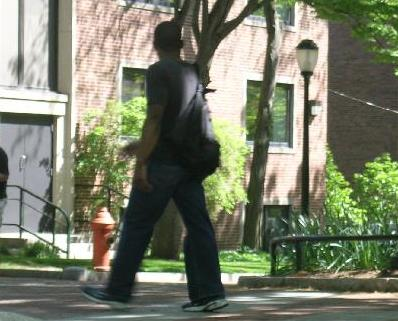

In [20]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

dict_keys(['boxes', 'labels', 'masks', 'image_id', 'area', 'iscrowd'])
tensor([[ 79.,  21., 228., 311.]])
load
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] [  0 255] (321, 398) <class 'numpy.ndarray'>


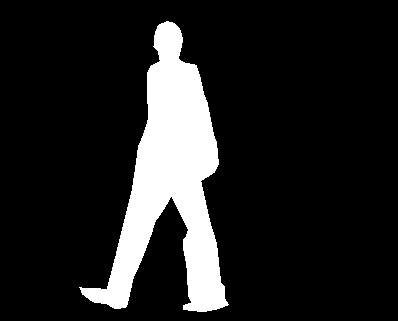

In [21]:
print(img2.keys())
print(img2['boxes'])
mshape = img2['masks'].shape
arr = np.zeros((mshape[1],mshape[2]),dtype=np.uint8)
for i in range(mshape[0]):
    print ("load")
    arr += img2['masks'][i].mul(255).byte().numpy()
print (arr, np.unique(arr), arr.shape, type(arr))
image = Image.fromarray(arr)
image

In [22]:
def get_rect(x, y, width, height):
    rect = [(x, y), (x+width, y), (x+width, y+height), (x, y+height), (x, y)]
    #rect = [(0, 0), (width, height)]
    
    return tuple(rect)

torch.Size([2, 1, 321, 398])
(398, 321)
(398, 321)


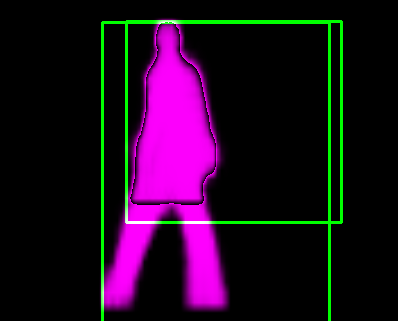

In [23]:
from PIL import ImageDraw
pshape = prediction[0]['masks'].shape
boxes = prediction[0]['boxes'].cpu().numpy()
print(prediction[0]['masks'].shape)

arr = np.zeros((pshape[2],pshape[3]),dtype=np.uint8)
for i in range(pshape[0]):
    arr += prediction[0]['masks'][i,0].mul(255).byte().cpu().numpy()
image = Image.fromarray(arr)


overlay = Image.new("L", (pshape[3], pshape[2]), 0)
draw = ImageDraw.Draw(overlay)
rects = [get_rect(*p) for p in boxes]

for rect in rects:
    draw.line([tuple(p) for p in rect], width=3, fill=500)


print(image.size)
print(overlay.size)

img = Image.merge("RGB", (image,overlay,image))
(image,overlay)
img